# Score Diffusion Model分数扩散模型理论与完整PyTorch代码详细解读

来自b站up主deep_thoughts 合集【PyTorch源码教程与前沿人工智能算法复现讲解】

P_62_Score Diffusion Model分数扩散模型理论与完整PyTorch代码详细解读：

https://www.bilibili.com/video/BV1Dd4y1A7oz/?spm_id_from=333.788&vd_source=18e91d849da09d846f771c89a366ed40

本期视频教程主要参考文献:
* Score-Based Generative Modeling through Stochastic Differential Equations
* Improved Techniques for Training Score-Based Generative Models
* Generative modeling by estimating gradients of the data distribution
* High-Resolution lmage Synthesis with Latent Diffusion Models

本期视频教程代码运行环境
* Kaggle免费GPU(每周免费时长约30小时，数据空间107G)，该环境比Mac本地训练效率提高约10倍。
* 初步对比了一下Google Colab的GPU，要比Kaggle GPU训练速度慢一点
* 本期教程编写的Score-based Model基于MNIST数据只训练了50 Epoch，采样效果仅供参考

# Warmup:Stable Diffusion 原理与实例
## Stable Diffusion原理
模型结构图:

![](./img/P62_1.png)

## Stable Diffusion实例

见视频中对模型生成效果的演示图片

## Yang Song Google Scholar

![](./img/P62_2.png)

## 1 Score and Naive Score-Based Models

![](./img/P62_3.png)

![](./img/P62_4.png)

![](./img/P62_5.png)

![](./img/P62_6.png)

![](./img/P62_7.png)

## 2 Noise Conditional Score Networks (NCSN)

![](./img/P62_8.png)

![](./img/P62_9.png)

![](./img/P62_10.png)

![](./img/P62_11.png)

![](./img/P62_12.png)

![](./img/P62_13.png)

![](./img/P62_14.png)

![](./img/P62_15.png)

## 3 Score-based generative modeling with stochastic differential equations(SDEs)

![](./img/P62_16.png)

![](./img/P62_17.png)

![](./img/P62_18.png)

![](./img/P62_19.png)

![](./img/P62_20.png)

![](./img/P62_21.png)

## 4 Pytorch Code Implementations

### 4.1 Define the U-net based Score Prediction Network

In [10]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

class TimeEncoding(nn.Module):
    """ 用于对时间进行特定傅里叶编码 """
    
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization, These weights are fixed
        #during optimization and are not trainable.
        self.w= nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    
    def forward(self,x):
        x_proj = x[:, None] * self.w[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
    """ A fully connected layer that reshapes outputs to feature maps. """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.dense(x)[..., None, None]  # 对输出扩充了最后两个维度
    
class ScoreNet(nn.Module):
    """ 基于U-net的时间依赖的分数估计模型 """
    
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """ Initialize a time-dependent score-based network.
        
        Args:
            marginal_prob_std: A function that takes time t and gives the standard
                deviation of the perturbation kernel p_{0t}(x(t)|x(0)).
            channels: The number of channels for feature maps of each resolution.
            embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(TimeEncoding(embed_dim=embed_dim),
                    nn.Linear(embed_dim, embed_dim))  # 时间编码层
        
        # U-net的编码器部分, 空间不断减小，通道不断增大
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)  # to skip connection
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)  # to skip connection
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)  # to skip connection
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)  # to skip connection
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        
        # U-net的解码器部分，空间不断增大，通道不断减小，并且有来自编码器部分的skip connection
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        
        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
        self.marginal_prob_std = marginal_prob_std
        
    def forward(self, x, t):
        # 对时间t进行编码
        embed = self.act(self.embed(t))
        
        # 编码器部分前向计算
        h1 = self.conv1(x)
        h1 += self.dense1(embed)  # 注入时间t
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)  # 注入时间t
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)  # 注入时间t
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)  # 注入时间t
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)
        
        # 解码器部分前向计算
        h = self.tconv4(h4)
        h += self.dense5(embed)  # 注入时间t
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))  # skip connection
        h += self.dense6(embed)  # 注入时间t
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))  # skip connection
        h += self.dense7(embed)  # 注入时间t
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))  # skip connection
        
        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]  # 目的是希望预测的分数的二阶范数逼近于真实分数的二阶范数
        
        return h

![](./img/P62_22.png)

In [11]:
device = 'cuda:0'  # cuda or cpu

def marginal_prob_std(t, sigma):
    """ 计算任意t时刻的扰动后条件高斯分布的标准差 """
    
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """ 计算任意t时刻的扩散系数，本例定义的SDE没有漂移系数 """
    
    return torch.tensor(sigma**t, device=device)

sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)  # 构建无参函数
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)  # 构建无参函数

In [12]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """ The loss function for training score-based generative models.
    
    Args:
        model: A Pytorch model instance that represents a 
            time-dependent score-based model.
        x: A mini-batch of training data.
        marginal_prob_std: A function that gives the standard deviation of 
            the perturbation kernel.
        eps: A tolerance value for numerical stability.
    """
    # Step1 从[0.00001, 0.9999]中随机生成batchsize个浮点型t
    random_t = torch.rand(x.shape[0], device=x.device) * (1. -eps) + eps
    
    # Step2 基于重参数技巧采样出分布p_t(x)的一个随机样本perturbed_x
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    
    # Step3 将当前的加噪样本和时间输入到Score Network中预测出分数score
    score = score_model(perturbed_x, random_t)
    
    # Step4 计算score matching loss
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

In [13]:
from copy import deepcopy

class EMA(nn.Module):
    def __init__(self, model, decay=0.9999, device=None):
        super(EMA, self).__init__()
        # make a copy of the model for accumulating moving average of weights
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device
        if self.device is not None:
            self.module.to(device=device)
            
    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))
                
    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)
        
    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)

### 4.3 Training score-based model on MNIST data

In [14]:
#@title Training (double click to expand or collapse)

import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm


score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs = 50  #@param {'type': 'integer'}
## size of a mini-batch
batch_size = 32  #@param {'type': 'integer'}
## learning rate
lr = 1e-4  #@param {'type': 'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.tqdm(range(n_epochs))

ema = EMA(score_model)
for epoch in tqdm_epoch:  # 训练速度：MacCPU 250s/Epoch， Kaggle GPU：30s/Epoch，GoogleColab：35s/Epoch，TPU 未测
    avg_loss = 0.
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema.update(score_model)
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    
    print('Average ScoreMatching Loss: {:5f}'.format(avg_loss / num_items))
    #torch.save(score_model.state_dict(), f'ckpt_{epoch}.pth')
    torch.save(score_model.state_dict(), f'ckpt.pth')
        

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]D:\anaconda3\envs\swin\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
  2%|█▋                                                                                 | 1/50 [00:53<43:30, 53.28s/it]

Average ScoreMatching Loss: 320.561302


  4%|███▎                                                                               | 2/50 [01:34<36:57, 46.21s/it]

Average ScoreMatching Loss: 71.545891


  6%|████▉                                                                              | 3/50 [02:14<34:08, 43.58s/it]

Average ScoreMatching Loss: 47.427567


  8%|██████▋                                                                            | 4/50 [02:55<32:32, 42.44s/it]

Average ScoreMatching Loss: 38.139268


 10%|████████▎                                                                          | 5/50 [03:36<31:22, 41.84s/it]

Average ScoreMatching Loss: 32.674894


 12%|█████████▉                                                                         | 6/50 [04:16<30:19, 41.35s/it]

Average ScoreMatching Loss: 29.146439


 14%|███████████▌                                                                       | 7/50 [04:57<29:24, 41.03s/it]

Average ScoreMatching Loss: 26.728903


 16%|█████████████▎                                                                     | 8/50 [05:37<28:32, 40.78s/it]

Average ScoreMatching Loss: 25.019814


 18%|██████████████▉                                                                    | 9/50 [06:17<27:43, 40.57s/it]

Average ScoreMatching Loss: 23.838943


 20%|████████████████▍                                                                 | 10/50 [06:58<27:03, 40.60s/it]

Average ScoreMatching Loss: 22.811329


 22%|██████████████████                                                                | 11/50 [07:38<26:20, 40.52s/it]

Average ScoreMatching Loss: 22.201774


 24%|███████████████████▋                                                              | 12/50 [08:19<25:46, 40.69s/it]

Average ScoreMatching Loss: 21.360711


 26%|█████████████████████▎                                                            | 13/50 [08:59<24:59, 40.54s/it]

Average ScoreMatching Loss: 21.129148


 28%|██████████████████████▉                                                           | 14/50 [09:39<24:10, 40.28s/it]

Average ScoreMatching Loss: 20.859563


 30%|████████████████████████▌                                                         | 15/50 [10:19<23:24, 40.14s/it]

Average ScoreMatching Loss: 20.254970


 32%|██████████████████████████▏                                                       | 16/50 [11:01<23:04, 40.72s/it]

Average ScoreMatching Loss: 20.115091


 34%|███████████████████████████▉                                                      | 17/50 [11:42<22:30, 40.91s/it]

Average ScoreMatching Loss: 19.605696


 36%|█████████████████████████████▌                                                    | 18/50 [12:23<21:42, 40.71s/it]

Average ScoreMatching Loss: 19.626377


 38%|███████████████████████████████▏                                                  | 19/50 [13:05<21:14, 41.10s/it]

Average ScoreMatching Loss: 19.618443


 40%|████████████████████████████████▊                                                 | 20/50 [13:46<20:40, 41.36s/it]

Average ScoreMatching Loss: 19.281909


 42%|██████████████████████████████████▍                                               | 21/50 [14:26<19:47, 40.95s/it]

Average ScoreMatching Loss: 18.931792


 44%|████████████████████████████████████                                              | 22/50 [15:07<19:04, 40.87s/it]

Average ScoreMatching Loss: 18.784319


 46%|█████████████████████████████████████▋                                            | 23/50 [15:50<18:35, 41.32s/it]

Average ScoreMatching Loss: 18.770555


 48%|███████████████████████████████████████▎                                          | 24/50 [16:32<18:03, 41.66s/it]

Average ScoreMatching Loss: 18.622496


 50%|█████████████████████████████████████████                                         | 25/50 [17:14<17:21, 41.64s/it]

Average ScoreMatching Loss: 18.576399


 52%|██████████████████████████████████████████▋                                       | 26/50 [17:55<16:40, 41.69s/it]

Average ScoreMatching Loss: 18.402835


 54%|████████████████████████████████████████████▎                                     | 27/50 [18:38<16:02, 41.86s/it]

Average ScoreMatching Loss: 18.256024


 56%|█████████████████████████████████████████████▉                                    | 28/50 [19:19<15:19, 41.79s/it]

Average ScoreMatching Loss: 18.177815


 58%|███████████████████████████████████████████████▌                                  | 29/50 [20:01<14:36, 41.73s/it]

Average ScoreMatching Loss: 18.248788


 60%|█████████████████████████████████████████████████▏                                | 30/50 [20:43<13:56, 41.83s/it]

Average ScoreMatching Loss: 18.024152


 62%|██████████████████████████████████████████████████▊                               | 31/50 [21:23<13:06, 41.41s/it]

Average ScoreMatching Loss: 17.948101


 64%|████████████████████████████████████████████████████▍                             | 32/50 [22:03<12:17, 40.95s/it]

Average ScoreMatching Loss: 18.086124


 66%|██████████████████████████████████████████████████████                            | 33/50 [22:44<11:34, 40.84s/it]

Average ScoreMatching Loss: 17.812051


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [23:23<10:44, 40.26s/it]

Average ScoreMatching Loss: 17.691274


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [24:02<09:59, 39.99s/it]

Average ScoreMatching Loss: 17.841560


 72%|███████████████████████████████████████████████████████████                       | 36/50 [24:42<09:21, 40.08s/it]

Average ScoreMatching Loss: 17.609686


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [25:23<08:41, 40.14s/it]

Average ScoreMatching Loss: 17.659093


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [26:03<08:01, 40.10s/it]

Average ScoreMatching Loss: 17.705373


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [26:42<07:18, 39.85s/it]

Average ScoreMatching Loss: 17.472154


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [27:22<06:39, 39.92s/it]

Average ScoreMatching Loss: 17.541501


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [28:02<05:59, 39.90s/it]

Average ScoreMatching Loss: 17.455140


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [28:42<05:19, 39.93s/it]

Average ScoreMatching Loss: 17.307715


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [29:22<04:40, 40.01s/it]

Average ScoreMatching Loss: 17.197051


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [30:03<04:01, 40.23s/it]

Average ScoreMatching Loss: 17.436766


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [30:44<03:23, 40.65s/it]

Average ScoreMatching Loss: 17.241638


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [31:25<02:41, 40.49s/it]

Average ScoreMatching Loss: 17.326967


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [32:05<02:01, 40.42s/it]

Average ScoreMatching Loss: 17.327187


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [32:45<01:20, 40.43s/it]

Average ScoreMatching Loss: 17.095100


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [33:26<00:40, 40.61s/it]

Average ScoreMatching Loss: 17.117226


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [34:07<00:00, 40.94s/it]

Average ScoreMatching Loss: 17.048473


![](./img/P62_23.png)

In [15]:
## The number of sampling steps.
num_steps = 500
def euler_sampler(score_model,
                  marginal_prob_std,
                  diffusion_coeff,
                  batch_size=64,
                  num_steps=num_steps,
                  device='cuda:0',
                  eps=1e-3):
    
    # Step1 定义初始时间1和先验分布的随机样本
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
        * marginal_prob_std(t)[:, None, None, None]
    
    # Step2 定义采样的你时间网格以及每一步的时间步长
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    
    # Step3 根据欧拉算法来求解逆时间SDE
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
            
    # Step4 取最后一步的期望值作为生成的样本
    return mean_x

![](./img/P62_24.png)

![](./img/P62_25.png)

In [27]:
signal_to_noise_ratio = 0.16
num_steps = 500

def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               snr=signal_to_noise_ratio,  # 多出来的一项
               device='cuda:0',
               eps=1e-3):
    """ Generate samples from score-based models with Predictor-Corrector method.
    
    Args:
        score_model: A PyTorch model that represents the time-dependent score-based model.
        marginal_prob_std: A function that gives the standard deviation
            of the perturbation kernel.
        diffusion_coeff: A function that gives the diffusion coefficient
            of the SDE.
        batch_size: The number of samplers to generate by calling this function once.
        num_steps: The number of sampling steps.
            Equivalent to the number of discretized time steps.
        device: 'cuda' for running on GPUs. and 'cpu' for running on CPUs.
        eps: The smallest time step for numerical stability.
        
    Returns:
        Samples.
    """
    # Step1 定义初始时间1和先验分布的随机样本
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
    
    # Step2 定义采样的你时间网格以及每一步的时间步长
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    
    # Step3 重复交替进行朗之万采样和逆时间SDE的欧拉数值求解
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            
            # Corrector step (Langevin MCMC)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm) **2
            #print(f"langevin_step_size={langevin_step_size}")
            
            for _ in range(10):
                x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)  # 朗之万采样迭代公式
                grad = score_model(x, batch_time_step)
                grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
                noise_norm = np.sqrt(np.prod(x.shape[1:]))
                langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
                #print(f"langevin_step_size={langevin_step_size}")
            
            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)
        
    # Step4 取最后一步的欧拉数值求解的期望值作为最终生成的样本
    return x_mean

![](./img/P62_26.png)

![](./img/P62_27.png)

In [24]:
from scipy import integrate
## The error tolerance for the black-box ODE solver
error_tolerance=1e-5 #param {'type':'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cuda:0',
                z=None,
                eps=1e-3):
    
    # step1 定义初始时间1和初始值x
    t = torch.ones(batch_size, device=device)
    if z is None:
        init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
            * marginal_prob_std(t)[:, None, None, None]
    else:
        init_x = z
        
    shape = init_x.shape

    # step2 定义分数预测函数和常微分函数
    def score_eval_wrapper(sample, time_steps):
        """A wrapper of the score-based model for use by the ODE solver."""
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0],))
        with torch.no_grad():
            score = score_model(sample, time_steps)
        return score.cpu().numpy().reshape((-1,)).astype(np.float64)
    
    def ode_func(t, x):
        """The ODE function for use by the ODE solver."""
        time_steps = np.ones((shape[0],)) * t
        g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
        return -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
    
    # step3 调用常微分求解算子来解出t=eps时刻的值，即预测的样本
    res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
    print(f"Number of function evaluations: {res.nfev}")
    
    x = torch.tensor(res.y[:, -1], device=device).reshape(shape)
    
    return x

### 4.7 导入训练好的MNIST模型并对比不同的采样算法

D:\anaconda3\envs\swin\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
  0%|                                                                                          | 0/500 [00:00<?, ?it/s]D:\anaconda3\envs\swin\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == "":
100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 193.51it/s]

<function euler_sampler at 0x00000125720D5948>采样耗时2.5868418216705322s


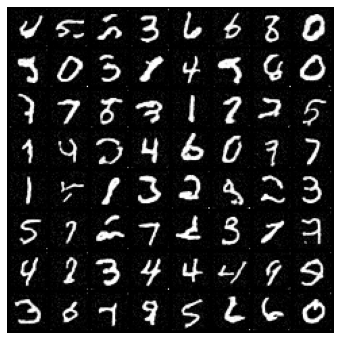

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:27<00:00, 18.26it/s]

<function pc_sampler at 0x00000125E3C30B88>采样耗时27.387885093688965s


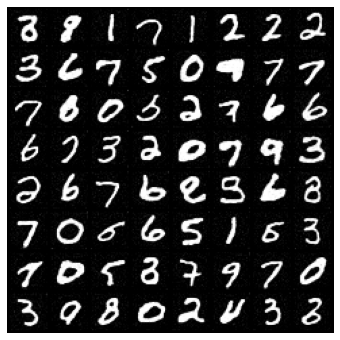

Number of function evaluations: 338
<function ode_sampler at 0x00000125720D5AF8>采样耗时1.8983216285705566s


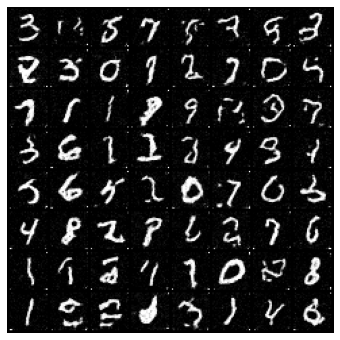

In [28]:
from torchvision.utils import make_grid
import time

## Load the pre-trained checkpoint from disk.
device = 'cuda:0'  # cuda
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64
for sampler in [euler_sampler, pc_sampler, ode_sampler]:
#sampler = pc_sampler  # ['euler_sampler', 'pc_sampler', 'ode_sampler']

    t1 = time.time()
    ## Generate samples using the specified sampler.
    samples = sampler(score_model,
                      marginal_prob_std_fn,
                      diffusion_coeff_fn,
                      sample_batch_size,
                      device=device)
    t2 = time.time()
    print(f"{str(sampler)}采样耗时{t2-t1}s")

    ## Sample visualization.
    samples = samples.clamp(0.0, 1.0)
    %matplotlib inline
    import matplotlib.pyplot as plt
    sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.show()

![](./img/P62_28.png)

In [44]:
def prior_likelihood(z, sigma):
    """ 先验高斯分布的对数似然 """
    shape =z.shape
    N = np.prod(shape[1:])
    return -N / 2.* torch.log(2*np.pi*sigma**2) - torch.sum(z**2, dim=(1,2,3)) / (2 * sigma**2)

def ode_likelihood(x,
                   score_model,
                   marginal_prob_std,
                   diffusion_coeff,
                   batch_size=64,
                   device='cuda:0',
                   eps=1e-5):
    """Compute the likelihood with probability flow ODE.
    
    Args :
        x:Input data.
        score_model: A PyTorch model representing the score-based model.
        marginal_prob_std: A function that gives the standard deviation of the
            perturbation kernel.
        diffusion coeff: A function that gives the diffusion coefficient of the
            forward SDE.
        batch_size: The batch size. Equals to the leading dimension of 'x'.
        device: 'cuda' for evaluation on GPUs, and 'cpu' for evaluation on CPUs.
        eps:A 'float' number. The smallest time step for numerical stability.
        
    Returns:
        z: The latent code for 'x'.
        bpd: The 1og-likelihoods in bits/dim.
    """
    # Draw the random Gaussian sample for Skilling-Hutchinson's estimator.
    epsilon = torch.randn_like(x)

    def divergence_eval(sample, time_steps, epsilon):
        """Compute the divergence of the score-based model with Skilling-Hutchinson."""
        with torch.enable_grad():
            sample.requires_grad_(True)
            score_e = torch.sum(score_model(sample, time_steps) * epsilon)
            grad_score_e = torch.autograd.grad(score_e, sample)[0]
        return torch.sum(grad_score_e * epsilon, dim=(1, 2, 3))

    shape = x.shape
    
    def score_eval_wrapper(sample, time_steps):
        """A wrapper for evaluating the score-based model for the black-box ODE solver."""
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
        with torch.no_grad():
            score = score_model(sample, time_steps)
        return score.cpu().numpy().reshape((-1,)).astype(np.float64)

    def divergence_eval_wrapper(sample, time_steps):
        """A wrapper for evaluating the divergence of score for the black-box opE solver."""
        with torch.no_grad():
            # Obtain x(t) by solving the probability flow ODE.
            sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
            time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
            # Compute likelihood.
            div = divergence_eval(sample, time_steps, epsilon)
            return div.cpu().numpy().reshape((-1,)).astype(np.float64)
    
    def ode_func(t, x):
        """The ODE function for the black-box solver."""
        time_steps = np.ones((shape[0],)) * t
        sample = x[:-shape[0]]
        logp = x[-shape[0]:]
        g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
        sample_grad = -0.5 * g**2 * score_eval_wrapper(sample, time_steps)
        logp_grad = -0.5 * g**2 * divergence_eval_wrapper(sample, time_steps)
        return np.concatenate([sample_grad, logp_grad], axis=0)
    
    init = np.concatenate([x.cpu().numpy().reshape((-1,)), np.zeros((shape[0],))], axis=0)
    # Black-box ODE solve
    res = integrate.solve_ivp(ode_func, (eps, 1.), init, rtol=1e-5, atol=1e-5, method='RK45')
    zp = torch.tensor(res.y[:, -1], device=device)
    z = zp[:-shape[0]].reshape(shape)
    delta_logp = zp[-shape[0]:].reshape(shape[0])
    sigma_max = marginal_prob_std(1.)
    prior_logp = prior_likelihood(z, sigma_max)
    bpd =-(prior_logp + delta_logp) / np.log(2)
    N = np.prod(shape[1:])
    bpd = bpd / N + 8.
    return z, bpd

In [46]:
batch_size = 32 #@param {'type':'integer'}
dataset = MNIST('.', train=False, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

all_bpds =0.
all_items = 0
try:
    tqdm_data = tqdm.tqdm(data_loader)
    for x, _ in tqdm_data:
        x = x.to(device)
        # uniform dequantization
        x = (x * 255. + torch.rand_like(x))/256.
        _, bpd = ode_likelihood(x, score_model, marginal_prob_std_fn,
                                diffusion_coeff_fn,
                                x.shape[0], device=device, eps=1e-5)
        all_bpds += bpd.sum()
        all_items += bpd.shape[0]
        tqdm_data.set_description("Averaye bits/dim: {:5f}".format(all_bpds / all_items))
        
except KeyboardInterrupt:
    # Remove the error message when interuptted by keyboard or GUI.
    pass

  0%|                                                                                          | 0/313 [00:00<?, ?it/s]D:\anaconda3\envs\swin\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == "":
D:\anaconda3\envs\swin\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
Averaye bits/dim: 3.899524: 100%|████████████████████████████████████████████████████| 313/313 [24:41<00:00,  4.73s/it]


## 5 总结

![](./img/P62_29.png)

![](./img/P62_30.png)

![](./img/P62_31.png)

![](./img/P62_33.png)